**Step 1.** Import necessary libraries

In [1]:
import os

from utils import config
from utils.data_processor import DataProcessor
from utils.common_utils import (
    get_scenario_map,
    get_filter_parameters
)
from utils.dataset import GraphDataset, GraphData

import torch
from torch_geometric.loader import DataLoader

from nuplan.planning.scenario_builder.nuplan_db.nuplan_scenario_utils import ScenarioMapping
from nuplan.planning.scenario_builder.scenario_filter import ScenarioFilter
from nuplan.planning.scenario_builder.nuplan_db.nuplan_scenario_builder import NuPlanScenarioBuilder
from nuplan.planning.utils.multithreading.worker_parallel import SingleMachineParallelExecutor

**Step 2** Construct a `data_processor` class

In [2]:
# nuplan arguments
scenarios_per_type = 1000
total_scenarios = None
shuffle_scenarios = False

sensor_root = None
db_files = None

# create folder for processed data
os.makedirs(config.SAVE_PATH, exist_ok=True)

# get scenarios
scenario_mapping = ScenarioMapping(
    scenario_map=get_scenario_map(), 
    subsample_ratio_override=0.5
)

builder = NuPlanScenarioBuilder(
    config.DATA_PATH, 
    config.MAP_PATH, 
    sensor_root, 
    db_files, 
    config.MAP_VERSION, 
    scenario_mapping=scenario_mapping
)

# scenarios for training
scenario_filter = ScenarioFilter(
    *get_filter_parameters(
        scenarios_per_type, 
        total_scenarios, 
        shuffle_scenarios
    )
)

# enable parallel process
worker = SingleMachineParallelExecutor(use_process_pool=True)

# get scenarios
scenarios = builder.get_scenarios(scenario_filter, worker)

Do data processing

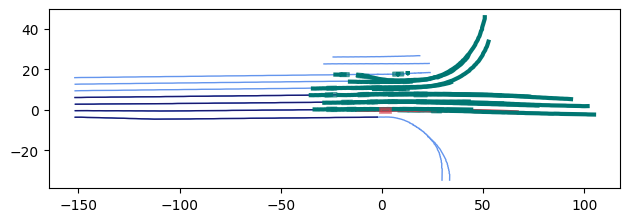

In [3]:
# pick a scenario
scenario = scenarios[10]

# do processing
data_processor = DataProcessor(scenario)
data, features = data_processor.process(debug=True)

In [4]:
features['GROUND_TRUTH'].values[0].shape

(1680, 2)

**Step 3** Load data

In [14]:
processed_data_path = config.SAVE_PATH
dataset = GraphDataset(processed_data_path)
batch_iter = DataLoader(dataset, batch_size=5)

# Check if CUDA is available and set the device accordingly
device = torch.device(
    'cuda0' if torch.cuda.is_available() else 'cpu'
)

# Get a single batch from the iterator and move it to the selected device    
batch = next(iter(batch_iter))
batch.x.shape

device

device(type='cpu')

**Step 4** Test Netwrok

In [6]:
from vectornet.subgraph import GraphLayerProp, SubGraph

subgraph_layer = GraphLayerProp(
    in_channels=batch.x.shape[1],
    hidden_unit=64,
    verbose=True
)

layer_out = subgraph_layer(
    batch.x.to(torch.float32), 
    batch.edge_index
)

subgraph = SubGraph(
    in_channels=batch.x.shape[1],
    num_subgraph_layres=3,
    hidden_unit=64
)

subgraph_out = subgraph(batch)

print(subgraph_out.x)

x before mlp: tensor([[  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
        ...,
        [-26.0665,  -9.7825, -24.8056,  ...,   0.0000,   0.0000,  67.0000],
        [-24.8056,  -8.8597, -23.5447,  ...,   0.0000,   0.0000,  67.0000],
        [-23.5447,  -7.9369, -22.2838,  ...,   0.0000,   0.0000,  67.0000]])
x after mlp: tensor([[ 0.6774,  0.0102, -0.4331,  ...,  1.0615,  0.0021, -0.0043],
        [ 0.6774,  0.0102, -0.4331,  ...,  1.0615,  0.0021, -0.0043],
        [ 0.6774,  0.0102, -0.4331,  ...,  1.0615,  0.0021, -0.0043],
        ...,
        [ 1.5332, -1.0982, -0.5367,  ...,  0.4256,  0.5000,  0.6285],
        [ 1.5440, -1.1123, -0.5368,  ...,  0.3883,  0.4986,  0.6018],
        [ 1.5477, -1.1200, -0.5300,  ...,  0.3432,  0.4963,  0.5823]],
       grad_fn=<AddmmBackward>)
x after mlp: tensor([[ 0.6774,  0.010

In [7]:
from vectornet.globalgraph import SelfAttentionLayer

self_atten_input = subgraph_out.x.view(-1, config.NUM_GRAPH, subgraph_out.num_features)

self_atten_layer = SelfAttentionLayer(
    in_channels=subgraph_out.num_features,
    global_graph_width=64
)

self_atten_out = self_atten_layer(self_atten_input)

In [13]:
from vectornet.vectornet import TrajPredMLP

agent_feature = self_atten_out[:, 0:config.NUM_AGENTS+1, :]
mlp_input = agent_feature.contiguous().view(-1, agent_feature.shape[2])

pred_mlp = TrajPredMLP(
    in_channels=agent_feature.shape[2],
    out_channels=(config.NUM_AGENTS + 1) * config.NUM_FUTURE_POSES,
    hidden_unit=64
)

pred_mlp_out = pred_mlp(self_atten_out)
pred_mlp_out.shape

torch.Size([5, 76, 1680])

In [9]:
import torch.nn as nn
import torch.nn.functional as F
from vectornet.vectornet import VectornetGNN

gnn = VectornetGNN(
    in_channels=batch.num_features,
    out_channels=(config.NUM_AGENTS + 1) * config.NUM_FUTURE_POSES
)

gnn_out = gnn(batch)
gnn_out.shape

torch.Size([105, 1680])